In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from itertools import product
from scipy import interpolate

import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# based on code from https://www.youtube.com/watch?v=OljTVUVzPpM&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=2&t=635s

In [3]:
# class Discriminator(nn.Module):
#     def __init__(self, in_features):
#         super().__init__()
#         self.disc = nn.Sequential(
#             nn.Linear(in_features, DISC_NODES),
#             nn.LeakyReLU(0.01),
#             nn.Linear(DISC_NODES, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.disc(x.float())

In [4]:
# class Generator(nn.Module):
#     def __init__(self, z_dim, map_dim):
#         super().__init__()
#         self.gen = nn.Sequential(
#             nn.Linear(z_dim, GEN_NODES),
#             nn.LeakyReLU(0.01),
#             nn.Linear(GEN_NODES, map_dim),
#             nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
#         )

#     def forward(self, x):
#         return self.gen(x)

In [5]:
# hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
# gen_nodes = 256
# disc_nodes = 128
# lr = 3e-5
# batch_size = 5
# num_epochs = 6

z_dim = 1024
map_dim = 400 * 400 * 1 # 16000
max_data_points = 6000

parameters = dict(
    # gen_nodes = [128, 256],
    # disc_nodes = [128, 256],
    # lr = [0.0001, 0.00001],
    # batch_size = [5, 10],
    # num_epochs = [10]
    gen_nodes = [256],
    disc_nodes = [128],
    lr = [0.0001, 0.00001],
    batch_size = [5, 10],
    num_epochs = [10],
)
param_values = [v for v in parameters.values()]
total_param_runs = np.prod([len(v) for v in parameters.values()])

In [6]:
print(device)

cuda


In [7]:
# disc = Discriminator(map_dim).to(device)
# gen = Generator(z_dim, map_dim).to(device)
# fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),] # modify training data by normalizng to a desired mean and std deviation
)

In [8]:
# Need to override __init__, __len__, __getitem__
# as per datasets requirement
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path, transform=None, shape = (100,100)):
        print("Loading paths dataset...")
        # Read in path files
        # Convert to x by y np arrays
        # add the np arrays to a list
        # set self.transform and self.data
        self.paths = [] # create a list to hold all paths read from file
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                # xvales which to interpolate on
                # want to interpolate on xvalues from the min xval in the path to the largest xval in the path
                self.xvals = np.linspace(int(min(self.path[:,0])), int(max(self.path[:,0])), int(max(self.path[:,0])-min(self.path[:,0])))
                self.xvals = self.xvals.astype(int)

                self.yvals = np.linspace(int(min(self.path[:,1])), int(max(self.path[:,1])), int(max(self.path[:,1])-min(self.path[:,1])))
                self.yvals = self.yvals.astype(int)

                # use to interpolate: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d 

                # interp_func = interpolate.interp2d(self.path[:,0], self.path[:,1], np.arange(1, len(self.path)+1), kind="cubic")
                # new_y = interp_func(self.path[:,0], self.path[:,1])[0,:]
                # new_y = np.array(new_y).astype(int)
                # print(new_y)
                
                # interpolate for all xvals using the paths from file's x and y values
                self.interp_path_x = np.interp(self.xvals, self.path[:,0], self.path[:,1])
                self.interp_path_x = np.array(self.interp_path_x).astype(int)

                self.interp_path_y = np.interp(self.yvals, self.interp_path_x, self.xvals)
                self.interp_path_y = np.array(self.interp_path_y).astype(int)

                # create a LxW matrix where all the values where path is equal to 1
                self.path_matrix = np.zeros(shape)
                self.path_matrix[self.interp_path_x, self.xvals] = 1
                self.path_matrix[self.yvals, self.interp_path_y] = 1


                
                self.paths.append(self.path_matrix) # add the path to paths list
        print("Done!")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        return self.paths[idx]


In [9]:
dataset = PathsDataset(path = "./data/map_20x20/", shape = (400,400))

Loading paths dataset...
Done!


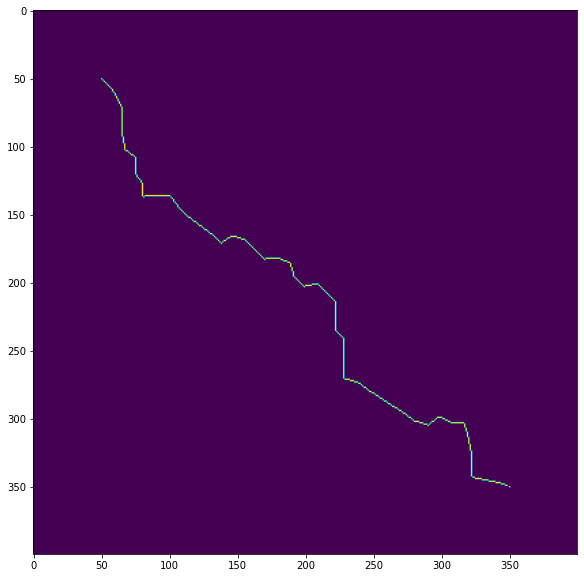

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(dataset[20])

In [11]:
# np.set_printoptions(threshold=sys.maxsize)
print(dataset[5])
print(len(dataset))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
10000


In [12]:
# writer_dis = SummaryWriter(f"logs/dis")
# writer_gen = SummaryWriter(f"logs/gen")
# writer_paths = SummaryWriter(f"logs/paths")
# writer_all = SummaryWriter(f"logs/all")

param_step = 0

for (gen_nodes,disc_nodes,lr,batch_size,num_epochs) in product(*param_values):

    writer = SummaryWriter(f"logs/run{param_step}")

    class Discriminator(nn.Module):
        def __init__(self, in_features):
            super().__init__()
            self.disc = nn.Sequential(
                nn.Linear(in_features, disc_nodes),
                nn.LeakyReLU(0.01),
                nn.Linear(disc_nodes, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            return self.disc(x.float())

    class Generator(nn.Module):
        def __init__(self, z_dim, map_dim):
            super().__init__()
            self.gen = nn.Sequential(
                nn.Linear(z_dim, gen_nodes),
                nn.LeakyReLU(0.01),
                nn.Linear(gen_nodes, map_dim),
                nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
            )

        def forward(self, x):
            return self.gen(x)

    disc = Discriminator(map_dim).to(device)
    gen = Generator(z_dim, map_dim).to(device)
    fixed_noise = torch.randn((batch_size, z_dim)).to(device)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    opt_disc = optim.Adam(disc.parameters(), lr=lr)
    opt_gen = optim.Adam(gen.parameters(), lr=lr)
    criterion = nn.BCELoss()

    loss_step = 0
    loss_step_acc = 0
    step = 0
    correct_gen = 0
    correct_dis = 0
    total_gen_loss = 0

    num_loops = batch_size*num_epochs

    step_rate = round(max_data_points/num_loops)

    for epoch in range(num_epochs):
        for batch_idx, real in enumerate(loader):
            real = real.view(-1, 160000).to(device)
            batch_size = real.shape[0]

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            noise = torch.randn(batch_size, z_dim).to(device)
            fake = gen(noise)
            disc_real = disc(real).view(-1)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake).view(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            disc.zero_grad()
            lossD.backward(retain_graph=True)
            opt_disc.step()

            # correct_dis += torch.sum(disc_fake == torch.zeros_like(disc_fake))

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            # where the second option of maximizing doesn't suffer from
            # saturating gradients
            output = disc(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

            # total_gen_loss += lossG
            # correct_gen += torch.sum(output == torch.ones_like(output))

            if loss_step % step_rate == 0:
                # saving loss + accuracy
                writer.add_scalar(f"Discriminator Loss", lossD, loss_step_acc)
                # writer.add_scalar(f"Discriminator Accuracy {param_step}", correct_dis/(loss_step+1), loss_step)

                writer.add_scalar(f"Generator Loss", lossG, loss_step_acc)
                # writer.add_scalar(f"Generator Accuracy  {param_step}", correct_gen/(loss_step+1), loss_step)

                loss_step_acc += 1

            loss_step += 1

            if batch_idx % (len(loader)//4) == 0:

                print(
                    f"Run [{param_step+1}/{total_param_runs}] Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(loader)}] \
                        Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
                )

                with torch.no_grad():
                    disc_fake = gen(fixed_noise)
                    fake = disc_fake.reshape(-1, 1, 400, 400)
                    data = real.reshape(-1, 1, 400, 400)
                    img_gen_output = torchvision.utils.make_grid(fake, normalize=True)
                    img_path_data = torchvision.utils.make_grid(data, normalize=True)

                    # if epoch == 0:
                    #     # graphs of general nn structure:
                    #     writer.add_graph(disc, disc_fake)
                    #     writer.add_graph(gen, fixed_noise)

                    # saving output
                    writer.add_image(
                        f"Generator Output", img_gen_output, global_step=step
                    )
                    writer.add_image(
                        f"Path Data", img_path_data, global_step=step
                    )

                step += 1
            
    

    #saving hyperparams:
    writer.add_hparams({"gen_nodes": gen_nodes, "disc_nodes": disc_nodes, "lr": lr, "batch_size": batch_size, "epochs": num_epochs}, {"gen loss": lossG}, run_name=f"run{param_step}")
    writer.close()
    param_step += 1

# writer_all.close()


Run [1/4] Epoch [1/10] Batch [0/2000]                         Loss D: 0.6946, loss G: 4.1414
Run [1/4] Epoch [1/10] Batch [500/2000]                         Loss D: 0.0918, loss G: 12.8884
Run [1/4] Epoch [1/10] Batch [1000/2000]                         Loss D: 0.0466, loss G: 46.6072
Run [1/4] Epoch [1/10] Batch [1500/2000]                         Loss D: 0.0971, loss G: 33.2885
Run [1/4] Epoch [2/10] Batch [0/2000]                         Loss D: 0.2619, loss G: 11.0890
Run [1/4] Epoch [2/10] Batch [500/2000]                         Loss D: 0.0861, loss G: 18.7723
Run [1/4] Epoch [2/10] Batch [1000/2000]                         Loss D: 0.0565, loss G: 10.6812
Run [1/4] Epoch [2/10] Batch [1500/2000]                         Loss D: 0.0493, loss G: 10.1373
Run [1/4] Epoch [3/10] Batch [0/2000]                         Loss D: 0.0653, loss G: 7.5888
Run [1/4] Epoch [3/10] Batch [500/2000]                         Loss D: 0.1052, loss G: 10.7950
Run [1/4] Epoch [3/10] Batch [1000/2000]    